# Pre-Fit and Post-Fit plots
This script plot the pre/post-fit plots using the outputs from running runcards.py and runcombine.py. Firstly, make a `fitDiagnostics.root` file containin the pre/post-fit distributions by activating cmsenv and running 
`combine -M FitDiagnostics cards-GluGluToSUEP_HT1000_T2p00_mS700.000_mPhi2.000*/combined.root -m 200 --rMin -1 --rMax 2 --saveShapes`. Note that any other datacard is also fine and should give the same prefit and background only postfit distributions, but make sure to adjust the r-interval (--rMin, --rMax) accordingly.


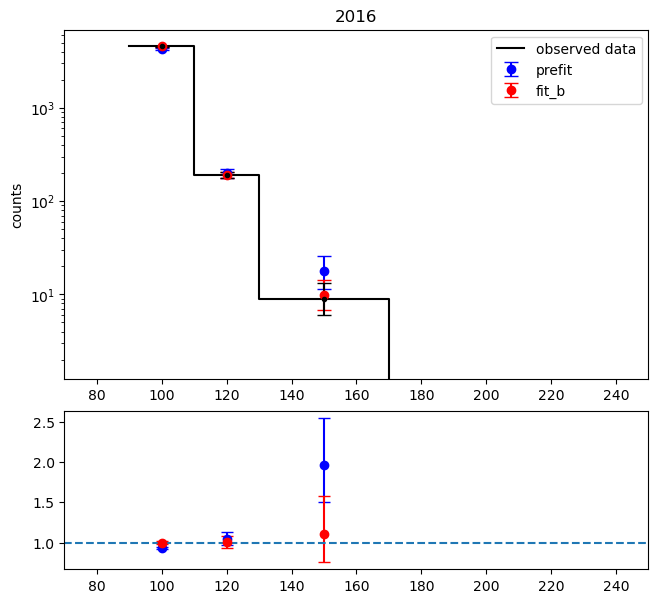

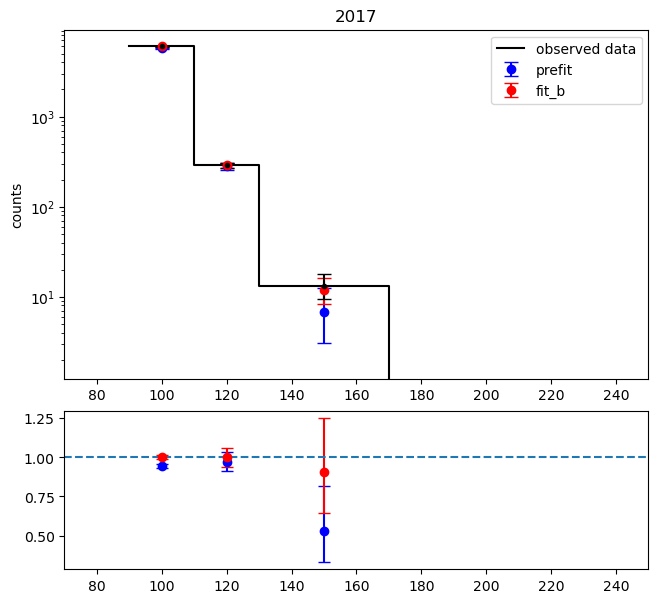

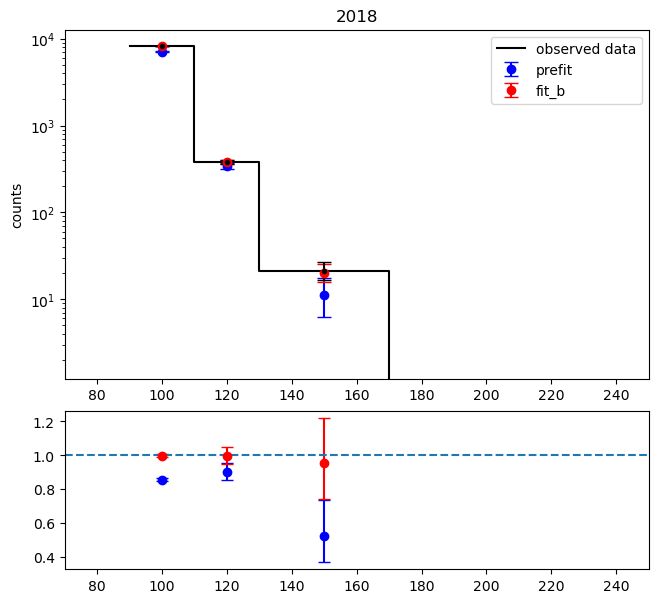

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import hist.intervals
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

filename = "fitDiagnostics.root"  # replace with your actual ROOT file path
file = uproot.open(filename)

bins = np.array([90,110,130,170,500])
centers = np.array( [(bins[i] + bins[i + 1])/2 for i in range(len(bins) - 1)])

def compute_poisson_interval(values, confidence=0.6827):
    alpha = 1 - confidence
    low = chi2.ppf(alpha / 2., 2 * values) / 2
    high = chi2.ppf(1. - alpha / 2., 2 * (values + 1)) / 2
    return low, high


for year in ['2016','2017','2018']:
    
    ### Collect data
    expected = {}
    for fit in ['fit_b','prefit']: #fit_s 

        data = np.array([])
        expected[fit] = np.array([]) 

        for sig_bins in ['Bin1Sig','Bin2Sig','Bin3Sig','Bin4Sig']: #['Bin0crF','Bin1crF','Bin2crF','Bin3crF','Bin4crF']

            name = 'shapes_{}/{}{};1'.format(fit,sig_bins,year)
            data = np.append(data,file[name]['data;1'].values()[1])
            histo = file[name]['total_covar;1'].to_boost()
            # print(file[name].keys())
            # print(histo.values())
            #print(file[name]['expected;1'].variances()[1])

            expected[fit] = np.append(expected[fit],file[name]['expected;1'].values()[0])
            

            
    ### Plot everything
    plt.figure(figsize=(8,10))

    plt.gcf().subplots_adjust(bottom=0.15, left=0.17)

    # Plot histograms
    ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)
    low, high = compute_poisson_interval(expected['prefit']) #the pre-fit distribution
    ax1.errorbar(centers, expected['prefit'],label='prefit',yerr=np.array([expected['prefit']-low,high-expected['prefit']])*2.2**0.5, fmt='o', capsize=5,c='b')
    low, high = compute_poisson_interval(expected['fit_b']) #the background only post-fit distribution
    ax1.errorbar(centers, expected['fit_b'],label='fit_b',yerr=[expected['fit_b']-low,high-expected['fit_b']], fmt='o', capsize=5,c='r')
    low, high = compute_poisson_interval(data)
    ax1.errorbar(centers, data,yerr=[data-low,high-data], fmt='.',c='black', capsize=5)
    ax1.step(bins, np.append(data,0),where='post',c='black',label='observed data')

    ax1.set_title(year)
    ax1.set_ylabel("counts")
    ax1.set_yscale('log')
    ax1.legend()

    # Plot ratios
    ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)

    ratio_prefit = np.divide( expected['prefit'], data, out=np.ones_like(data), where=data!=0) #Overestimate
    ratio_fit_b = np.divide( expected['fit_b'], data, out=np.ones_like(data), where=data!=0) #Overestimate

    #Calculate errors
    prefit_err = hist.intervals.ratio_uncertainty( expected['prefit'],data) #This ratio uncertainty is the poisson interval (for a coverage of 0.68) divided by sig
    fit_b_err = hist.intervals.ratio_uncertainty( expected['fit_b'],data)

    ax2.errorbar(centers, ratio_prefit,fmt='o', color='b', label = 'prefit',yerr= prefit_err,capsize=4)
    ax2.errorbar(centers, ratio_fit_b,fmt='o', color='r', label = 'fit_b',yerr= fit_b_err,capsize=4)
    ax2.axhline(1,ls='--')
    ax2.set_xlim([70,250])

    # plt.savefig("/home/submit/pvanstee/public_html/SUEP/closure_uncertainties/{}".format(year))
    plt.show()

